In [ ]:
!pip install -qU \
        datasets \
        xgboost \
        keras_core \
        scikit-learn-intelex \
        imbalanced-learn \
        wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.3/110.3 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires 

In [ ]:
import gc

import numpy as np
import pandas as pd
from dataclasses import dataclass

import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
import seaborn as sns

import datasets

import wandb
wandb.login(key=userdata.get('WANDB_KEY'))

from wandb.integration.keras import WandbMetricsLogger

from sklearnex import patch_sklearn
patch_sklearn()

In [ ]:
@dataclass(kw_only=True)
class Config:
    seed: int = 2024
    batch_size: int = 32
    epochs: int = 50
    dataset_ckpt: str = "Falah/Alzheimer_MRI"
    image_size: tuple[int, int] = (128, 128)
    n_splits: int = 5
    project_name: str = "sbcas-ensemble"
    num_channels: int = 1

In [ ]:
dataset = datasets.load_dataset(Config.dataset_ckpt)
dataset = datasets.concatenate_datasets([dataset["train"], dataset["test"]])
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


README.md:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

(…)-00000-of-00001-c08a401c53fe5312.parquet:   0%|          | 0.00/22.6M [00:00<?, ?B/s]

(…)-00000-of-00001-44110b9df98c5585.parquet:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 6400
})

In [ ]:
id2label = {
    0: "mild_demented",
    1: "moderate_demented",
    2: "non_demented",
    3: "very_mild_demented"
}
label2id = {v: k for k, v in id2label.items()}
num_classes = len(id2label)
class_labels = list(id2label.keys())
class_names = [id2label[i] for i in sorted(class_labels)]

print(label2id)
print(id2label)

{'mild_demented': 0, 'moderate_demented': 1, 'non_demented': 2, 'very_mild_demented': 3}
{0: 'mild_demented', 1: 'moderate_demented', 2: 'non_demented', 3: 'very_mild_demented'}


In [ ]:
dataset = dataset.map(lambda record: {"category": id2label.get(record["label"])})
dataset

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label', 'category'],
    num_rows: 6400
})

In [ ]:
pd.Series(dataset["category"]).value_counts()

,count
non_demented,3200
very_mild_demented,2240
mild_demented,896
moderate_demented,64


In [ ]:
classes = ["mild_demented", "moderate_demented", "non_demented", "very_mild_demented"]
examples_per_class = 5

# Filtrar exemplos para cada classe
examples = {cls: [] for cls in classes}
for record in dataset:
    if len(examples[record["category"]]) < examples_per_class:
        examples[record["category"]].append(record["image"])

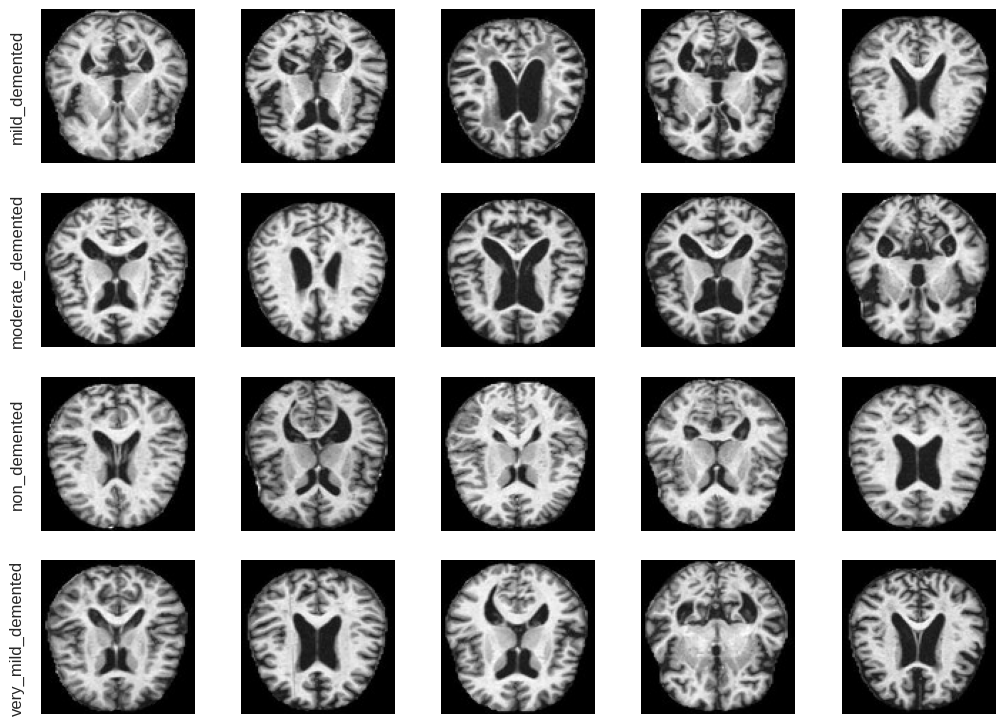

In [ ]:
CROP = 10
left, top, right, bottom = CROP, CROP, 128-CROP, 128-CROP
fig, axes = plt.subplots(len(classes), examples_per_class, figsize=(10.5, 7.5))

for i, cls in enumerate(classes):
    for j, img in enumerate(examples[cls]):
        ax = axes[i, j]
        ax.imshow(img.crop((left, top, right, bottom)), cmap="gray")
        ax.axis("off")
        if j == 0:
            ax.text(-0.15, 0.5, f"{cls}", fontsize=12, rotation=90, va='center',
                    ha='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

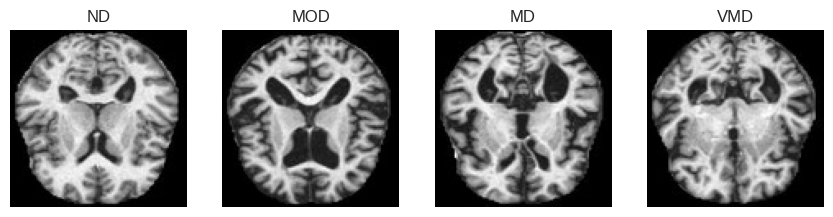

In [ ]:
classes = [ "non_demented", "moderate_demented", "mild_demented", "very_mild_demented"]
map = {'mild_demented': "MD", 'moderate_demented': "MOD", 'non_demented': "ND", 'very_mild_demented': "VMD"}

examples_per_class = 4
fig, axes = plt.subplots(1, len(classes), figsize=(10.5, 3.5))

for i, cls in enumerate(classes):
    for j in range(examples_per_class):
        ax = axes[i] if examples_per_class == 1 else axes[i]
        img = examples[cls][j]
        ax.imshow(img.crop((left, top, right, bottom)), cmap="gray")
        ax.axis("off")
        ax.set_title(map[cls], fontsize=12)

plt.savefig("data2.png", bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
images = np.repeat(np.array(dataset["image"])[..., None], 3, -1).astype(float)
labels = pd.get_dummies(np.array(dataset["label"]), dtype=float).values

In [ ]:
images.shape, labels.shape

# Modeling

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_core as K
from keras_core import layers, optimizers, callbacks, ops
import tensorflow as tf

from imblearn.over_sampling import ADASYN
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_auc_score,
    matthews_corrcoef
)

from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from xgboost import XGBClassifier
from wandb.integration.xgboost import WandbCallback as XGBWandBCallback

Using TensorFlow backend


In [ ]:
from typing import Callable

class EnsembleModel(K.Model):
    def __init__(
            self,
            model_a: Callable,
            preprocessor_a: Callable,
            model_b: Callable,
            preprocessor_b: Callable,
            model_c: Callable,
            preprocessor_c: Callable,
            num_classes: int
        ) -> None:

        super(EnsembleModel, self).__init__()
        self.model_a = model_a
        self.preprocessor_a = preprocessor_a

        self.model_b = model_b
        self.preprocessor_b = preprocessor_b

        self.model_c = model_c
        self.preprocessor_c = preprocessor_c

        self.dropout = layers.Dropout(0.1)
        self.classifier = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        x_a = self.model_a(self.preprocessor_a(inputs))
        x_b = self.model_b(self.preprocessor_b(inputs))
        x_c = self.model_c(self.preprocessor_c(inputs))

        x = ops.concatenate([x_a, x_b, x_c], axis=1)
        # x = self.dropout(x)
        out = self.classifier(x)

        return out


class ModelContainer(K.Model):
    def __init__(self, model: Callable, preprocessor: Callable) -> None:
        super(ModelContainer, self).__init__()

        self.model = model
        self.preprocessor = preprocessor
        self.dropout = layers.Dropout(0.1)
        self.classifier = layers.Dense(len(classes), activation="softmax")

    def call(self, inputs):
        x = self.preprocessor(inputs)
        x = self.model(x)
        # x = self.dropout(x)
        out = self.classifier(x)

        return out

# ResNet-101

In [ ]:
preprocessor_a = K.applications.resnet.preprocess_input
model_a = K.applications.ResNet101(
    include_top=False,
    input_shape=Config.image_size + (3,),
    weights="imagenet",
    pooling="avg"
)
model_a.trainable = False

# freeze weights
for layer in model_a.layers:
    if hasattr(layer, "trainable"):
        layer.trainable = False

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model_1 = ModelContainer(model_a, preprocessor_a)
model_1.summary(show_trainable=True)

Model: "model_container_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                    ┃    Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━┩
│ resnet101 (Functional)              │ ?                               │ 42,658,176 │    N    │
├─────────────────────────────────────┼─────────────────────────────────┼────────────┼─────────┤
│ dropout_2 (Dropout)                 │ ?                               │          0 │    -    │
├─────────────────────────────────────┼─────────────────────────────────┼────────────┼─────────┤
│ dense_2 (Dense)                     │ ?                               │          0 │    -    │
│                                     │                                 │  (unbuilt) │         │
└─────────────────────────────────────┴─────────────────────────────────┴────────────┴─────────┘

 Total params: 42,658,176 (162.73 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 42,658,176 (162.73 MB)

In [ ]:
images[0:1].shape

(1, 128, 128, 3)

In [ ]:
model_1(images[0:8])

<tf.Tensor: shape=(8, 4), dtype=float32, numpy=
array([[6.2512231e-01, 3.9979182e-02, 2.5034205e-03, 3.3239508e-01],
       [7.2641098e-01, 1.4011220e-02, 3.8412425e-03, 2.5573647e-01],
       [8.0486071e-01, 2.7092965e-02, 2.9779051e-03, 1.6506836e-01],
       [2.1105671e-01, 8.8718925e-03, 5.2914862e-04, 7.7954215e-01],
       [1.7203264e-01, 4.9683442e-03, 1.0457947e-03, 8.2195318e-01],
       [2.1827079e-01, 5.6733377e-02, 4.8486963e-02, 6.7650890e-01],
       [2.1253313e-01, 3.6861286e-02, 3.3386154e-03, 7.4726695e-01],
       [2.7495331e-01, 4.1001465e-02, 5.4875610e-04, 6.8349648e-01]],
      dtype=float32)>

# DenseNet-121

In [ ]:
preprocessor_b = K.applications.densenet.preprocess_input
model_b = K.applications.DenseNet121(
    include_top=False,
    input_shape=Config.image_size + (3,),
    weights="imagenet",
    pooling="avg"
)
model_b.trainable = False

# freeze weights
for layer in model_b.layers:
    if hasattr(layer, "trainable"):
        layer.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model_2 = ModelContainer(model_b, preprocessor_b)
model_2.summary(show_trainable=True)

Model: "model_container_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                    ┃    Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━┩
│ densenet121 (Functional)            │ ?                               │  7,037,504 │    N    │
├─────────────────────────────────────┼─────────────────────────────────┼────────────┼─────────┤
│ dropout_3 (Dropout)                 │ ?                               │          0 │    -    │
├─────────────────────────────────────┼─────────────────────────────────┼────────────┼─────────┤
│ dense_3 (Dense)                     │ ?                               │          0 │    -    │
│                                     │                                 │  (unbuilt) │         │
└─────────────────────────────────────┴─────────────────────────────────┴────────────┴─────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
model_2(images[0:8])

<tf.Tensor: shape=(8, 4), dtype=float32, numpy=
array([[0.02246469, 0.1830017 , 0.14029017, 0.6542434 ],
       [0.02236523, 0.09745324, 0.05701097, 0.8231705 ],
       [0.00750777, 0.8123213 , 0.05698798, 0.12318299],
       [0.02648427, 0.35382834, 0.3348403 , 0.2848471 ],
       [0.00435599, 0.4064755 , 0.00461789, 0.5845506 ],
       [0.00527025, 0.80547804, 0.06141765, 0.12783399],
       [0.07182296, 0.4066607 , 0.08564033, 0.43587604],
       [0.03873644, 0.57665735, 0.15496011, 0.22964613]], dtype=float32)>

# VGG-16

In [ ]:
preprocessor_c = K.applications.vgg16.preprocess_input
model_c = K.applications.VGG16(
    include_top=False,
    input_shape=Config.image_size + (3,),
    weights="imagenet",
    pooling="avg"
)
model_c.trainable = False

# freeze weights
for layer in model_c.layers:
    if hasattr(layer, "trainable"):
        layer.trainable = False

In [ ]:
model_c(preprocessor_c(images[0:8]))

<tf.Tensor: shape=(8, 512), dtype=float32, numpy=
array([[ 1.0724632 ,  0.        , 15.379693  , ...,  0.        ,
         0.36822283,  0.        ],
       [25.216246  ,  0.        , 13.937988  , ...,  0.        ,
         0.        ,  0.        ],
       [18.001457  ,  0.        ,  8.43585   , ...,  3.5581737 ,
         0.28501934,  0.        ],
       ...,
       [ 9.462655  ,  0.        , 12.721459  , ...,  0.        ,
         0.12018949,  0.        ],
       [40.333927  ,  0.        , 13.175235  , ...,  0.47318473,
         0.        ,  0.        ],
       [ 6.7984753 ,  0.28665233, 24.549044  , ...,  0.        ,
         0.42874354,  0.        ]], dtype=float32)>

# Ensemble

In [ ]:
ensemble = EnsembleModel(
    model_a, preprocessor_a,
    model_b, preprocessor_b,
    model_c, preprocessor_c,
    len(classes)
)

ensemble.summary(show_trainable=True)

Model: "ensemble_model_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                    ┃    Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━┩
│ resnet101 (Functional)              │ ?                               │ 42,658,176 │    N    │
├─────────────────────────────────────┼─────────────────────────────────┼────────────┼─────────┤
│ densenet121 (Functional)            │ ?                               │  7,037,504 │    N    │
├─────────────────────────────────────┼─────────────────────────────────┼────────────┼─────────┤
│ vgg16 (Functional)                  │ ?                               │ 14,714,688 │    N    │
├─────────────────────────────────────┼─────────────────────────────────┼────────────┼─────────┤
│ dropout_8 (Dropout)                 │ ?                               │          0 │    -    │
├─────────────────────────────────────┼─────────────────────────────────┼────────────┼─────────┤
│ dense_8 (Dense)                     │ ?                               │          0 │    -    │
│                                     │                                 │  (unbuilt) │         │
└─────────────────────────────────────┴─────────────────────────────────┴────────────┴─────────┘

 Total params: 64,410,368 (245.71 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 64,410,368 (245.71 MB)

In [ ]:
ensemble(images[0:8])

<tf.Tensor: shape=(8, 4), dtype=float32, numpy=
array([[1.6942419e-01, 7.4195200e-01, 6.1577607e-02, 2.7046151e-02],
       [6.8780285e-01, 3.0162930e-01, 9.6116401e-03, 9.5620815e-04],
       [5.3426541e-02, 9.3662566e-01, 9.7836126e-03, 1.6422370e-04],
       [8.7546295e-01, 5.9496798e-02, 4.9933136e-02, 1.5107101e-02],
       [9.1402686e-01, 1.7726883e-02, 4.3688409e-02, 2.4557790e-02],
       [6.8102831e-01, 1.1183433e-01, 1.8093541e-01, 2.6201975e-02],
       [8.1618565e-01, 1.7922364e-01, 2.0533418e-03, 2.5373213e-03],
       [4.0289184e-01, 4.6533224e-01, 7.2252683e-02, 5.9523229e-02]],
      dtype=float32)>

In [ ]:
def create_resnet_101() -> Callable:
    preprocessor = K.applications.resnet.preprocess_input
    model = K.applications.ResNet101(
        include_top=False,
        input_shape=Config.image_size + (3,),
        weights="imagenet",
        pooling="avg"
    )
    model.trainable = False

    # freeze weights
    for layer in model.layers:
        if hasattr(layer, "trainable"):
            layer.trainable = False

    return ModelContainer(model, preprocessor)


def create_densenet_121() -> Callable:
    preprocessor = K.applications.densenet.preprocess_input
    model = K.applications.DenseNet121(
        include_top=False,
        input_shape=Config.image_size + (3,),
        weights="imagenet",
        pooling="avg"
    )
    model.trainable = False

    # freeze weights
    for layer in model.layers:
        if hasattr(layer, "trainable"):
            layer.trainable = False

    return ModelContainer(model, preprocessor)


def create_vgg_16() -> Callable:
    preprocessor = K.applications.vgg16.preprocess_input
    model = K.applications.VGG16(
        include_top=False,
        input_shape=Config.image_size + (3,),
        weights="imagenet",
        pooling="avg"
    )
    model.trainable = False

    # freeze weights
    for layer in model.layers:
        if hasattr(layer, "trainable"):
            layer.trainable = False

    return ModelContainer(model, preprocessor)


def create_ensemble() -> Callable:
    resnet = create_resnet_101()
    densenet = create_densenet_121()
    vgg = create_vgg_16()

    ensemble = EnsembleModel(
        resnet.model, resnet.preprocessor,
        densenet.model, densenet.preprocessor,
        vgg.model, vgg.preprocessor,
        len(classes)
    )

    return ensemble

In [ ]:
len(dataset["label"]), labels.shape

(6400, (6400, 4))

# Ensemble (XGB, RF)

In [ ]:
images_ensemble_list = []
for i in range(len(dataset)):
    img = dataset[i]['image'].convert('L').resize(Config.image_size) # Grayscale
    images_ensemble_list.append(np.array(img).flatten())

# images_ensemble = np.array(dataset["image"]).reshape(6400, -1)
images_ensemble = np.array(images_ensemble_list)
labels_ensemble = np.array(dataset["label"])

images_ensemble.shape, labels_ensemble.shape

In [ ]:
clf_xgb = XGBClassifier(
    n_estimators=120, device="cuda", random_state=Config.seed,
    objective='multi:softprob', num_class=num_classes
)
clf_rf = RandomForestClassifier(
    n_estimators=120, random_state=Config.seed, class_weight='balanced'
)
clf_svc = SVC(random_state=Config.seed, class_weight='balanced', probability=True)
clf_lr = LogisticRegression(random_state=Config.seed, class_weight='balanced')
clf_knn = KNeighborsClassifier(n_neighbors=5)

In [ ]:
clf_voting_all = VotingClassifier(
    estimators=[
        ("xgb", clf_xgb), ("rf", clf_rf), ("svc", clf_svc),
        ("lr", clf_lr), ("knn", clf_knn)
    ],
    voting="soft"
)

clf_voting_few = VotingClassifier(
    estimators=[
        ("xgb", clf_xgb), ("rf", clf_rf), ("knn", clf_knn)
    ],
    voting="soft"
)

In [ ]:
model_factories = {
    "xgb": clf_xgb,
    "rf": clf_rf,
    "svc": clf_svc,
    "lr": clf_lr,
    "knn": clf_knn,
    "voting_all": clf_voting_all,
    "voting_few": clf_voting_few,
}

all_fold_metrics = {name: {} for name in model_factories.keys()}

kf = StratifiedKFold(n_splits=Config.n_splits, shuffle=True, random_state=Config.seed)

for model_name, current_model in model_factories.items():
    fold_metrics_list = []
    print(f"===== Training Model: {model_name} =====")

    for fold, (train_idx, val_idx) in enumerate(kf.split(images_ensemble, labels_ensemble)):
        print(f"--- Model:{model_name} | Fold:{fold + 1}/{Config.n_splits} ---")

        X_train, X_val = images_ensemble[train_idx], images_ensemble[val_idx]
        y_train, y_val = labels_ensemble[train_idx], labels_ensemble[val_idx]

        adasyn = ADASYN(random_state=Config.seed)
        X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)
        print(f"class distribution: {np.bincount(y_train)} -> {np.bincount(y_train_resampled)}")

        run = wandb.init(
            project=Config.project_name,
            name=f"sklearn-{model_name}-fold-{fold}",
            reinit=True
        )

        if model_name == "xgb":
            current_model.fit(
                X_train_resampled, y_train_resampled,
                eval_set=[(X_val, y_val)],
                verbose=False
            )

        else:
            current_model.fit(X_train_resampled, y_train_resampled)

        y_preds = current_model.predict(X_val)
        fold_results = {}

        fold_results["accuracy"] = accuracy_score(y_val, y_preds)
        fold_results["mcc"] = matthews_corrcoef(y_val, y_preds)

        # 1. per-class precision, recall, f1-score, and support
        precision_per, recall_per, f1_per, support_per = precision_recall_fscore_support(
            y_val, y_preds, labels=class_labels, zero_division=0
        )

        for i, label_int in enumerate(class_labels):
            label_name = id2label[label_int]
            fold_results[f"precision_{label_name}"] = precision_per[i]
            fold_results[f"recall_{label_name}"] = recall_per[i]
            fold_results[f"f1_{label_name}"] = f1_per[i]
            fold_results[f"support_{label_name}"] = support_per[i]

        # 2. macro precision, recall, f1-score, and support
        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
            y_val, y_preds, average="macro", zero_division=0
        )
        fold_results["precision_macro"] = precision_macro
        fold_results["recall_macro"] = recall_macro
        fold_results["f1_macro"] = f1_macro


        # 3. micro precision, recall, f1-score, and support
        precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
            y_val, y_preds, average="micro", zero_division=0
        )
        fold_results["precision_micro"] = precision_micro
        fold_results["recall_micro"] = recall_micro
        fold_results["f1_micro"] = f1_micro

        # auc
        if hasattr(current_model, "predict_proba"):
            y_preds_proba = current_model.predict_proba(X_val)
            y_val_binarized = label_binarize(y_val, classes=class_labels)

            for i, label_int in enumerate(class_labels):
                label_name = id2label[label_int]

                if np.sum(y_val_binarized[:, i]) > 0:
                    auc_roc = roc_auc_score(y_val_binarized[:, i], y_preds_proba[:, i])
                    fold_results[f"auc_roc_{label_name}"] = auc_roc
                else:
                    fold_results[f"auc_roc_{label_name}"] = float('nan')

        else:
            for label_int in class_labels:
                fold_results[f"auc_roc_{id2label[label_int]}"] = float('nan')

            fold_results["auc_roc_macro"] = float('nan')

        wandb.log({f"eval_{k}": v for k, v in fold_results.items()})

        cm = confusion_matrix(y_val, y_preds, labels=class_labels)

        wandb.log({
            "confusion_matrix": wandb.plot.confusion_matrix(
                preds=y_preds, y_true=y_val, class_names=class_names
            )
        })

        fold_metrics_list.append(fold_results)
        run.finish()

    avg_metrics = pd.DataFrame(fold_metrics_list).mean().to_dict()
    std_metrics = pd.DataFrame(fold_metrics_list).std().to_dict()
    all_fold_metrics[model_name] = {"avg": avg_metrics, "std": std_metrics}

    wandb.init(
        project=Config.project_name,
        name=f"sklearn-{model_name}-summary",
        reinit=True
    )

    summary_log = {}
    for metric, value in avg_metrics.items():
        summary_log[f"avg_val_{metric}"] = value

    for metric, value in std_metrics.items():
        summary_log[f"std_val_{metric}"] = value

    wandb.log(summary_log)
    wandb.finish()

    gc.collect()

# Deep CNN

In [ ]:
def preprocess_keras_image(example, image_size, num_channels):
    img = example['image']
    if img.mode!= ('L' if num_channels == 1 else 'RGB'):
        img = img.convert('L' if num_channels == 1 else 'RGB')

    img = img.resize(image_size)
    img_array = np.array(img).astype(float)

    if num_channels == 1 and len(img_array.shape) == 2:
        img_array = np.expand_dims(img_array, axis=-1)

    if num_channels == 3 and img_array.shape[-1] == 1:
        img_array = np.concatenate([img_array] * 3, axis=-1)

    return img_array

In [ ]:
all_images = np.array([
    preprocess_keras_image(dataset[i], Config.image_size, 3)
     for i in range(len(dataset))
])

all_labels_int = np.array(dataset["label"])
all_labels_one_hot = K.utils.to_categorical(all_labels_int, num_classes=num_classes)

In [ ]:
all_images.shape

(6400, 128, 128, 3)

In [ ]:
np.Inf = np.inf

In [ ]:
model_factories = {
    "resnet": create_resnet_101,
    "densenet": create_densenet_121,
    "vgg": create_vgg_16,
    "ensemble": create_ensemble
}

all_fold_metrics = {name: {} for name in model_factories.keys()}

kf = StratifiedKFold(n_splits=Config.n_splits, shuffle=True, random_state=Config.seed)

for model_name, current_model in model_factories.items():
    fold_metrics_list = []
    print(f"===== Training Model: {model_name} =====")

    for fold, (train_idx, val_idx) in enumerate(kf.split(all_images, all_labels_int)):
        print(f"--- Model:{model_name} | Fold:{fold + 1}/{Config.n_splits} ---")

        X_train_fold, X_val_fold = all_images[train_idx], all_images[val_idx]
        y_train_fold_one_hot, y_val_fold_one_hot = all_labels_one_hot[train_idx], all_labels_one_hot[val_idx]
        y_train_fold_int, y_val_fold_int = all_labels_int[train_idx], all_labels_int[val_idx]

        print(X_train_fold.shape)
        X_train_reshaped = X_train_fold.reshape(X_train_fold.shape[0], -1)
        adasyn = ADASYN(random_state=Config.seed)

        X_train_res_flat, y_train_res_int = adasyn.fit_resample(X_train_reshaped, y_train_fold_int)
        X_train_res = X_train_res_flat.reshape(-1, Config.image_size[0], Config.image_size[1], 3)

        y_train_res_one_hot = K.utils.to_categorical(y_train_res_int, num_classes=num_classes)
        print(f"class distribution: {np.bincount(y_train_fold_int)} -> {np.bincount(y_train_res_int)}")

        train_dataset = (
            tf.data.Dataset.from_tensor_slices((X_train_res, y_train_res_one_hot))
            .shuffle(buffer_size=len(X_train_res), seed=Config.seed)
            .batch(Config.batch_size)
            .cache()
            .prefetch(tf.data.AUTOTUNE)
        )

        validation_dataset = (
            tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold_one_hot))
            .batch(Config.batch_size)
            .cache()
            .prefetch(tf.data.AUTOTUNE)
        )

        X_train_fold, y_train_fold_one_hot = None, None
        X_train_reshaped, X_train_res_flat = None, None
        gc.collect()
        K.utils.clear_session()
        model = current_model()

        model.compile(
            loss="categorical_crossentropy",
            optimizer=optimizers.RMSprop(learning_rate=0.01),
            # optimizer="adamw",
            metrics=["accuracy", "auc", "precision", "recall"]
        )

        run = wandb.init(
            project=Config.project_name,
            name=f"keras-{model_name}-fold-{fold}-rmsprop",
            config={
                "fold": fold, "epochs": Config.epochs, "batch_size": Config.batch_size,
                "optimizer": "adam", "loss_fn": "ce"
            },
            reinit=True
        )

        history = model.fit(
            train_dataset,
            validation_data=validation_dataset,
            epochs=Config.epochs,
            verbose=1,
            callbacks=[
                WandbMetricsLogger(),
                # callbacks.ReduceLROnPlateau(
                #     monitor="val_loss",
                #     factor=0.1,
                #     patience=10,
                #     min_lr=1e-5
                # )
                callbacks.ReduceLROnPlateau(
                    monitor="val_loss",
                    factor=0.5,
                    patience=5,
                    min_lr=1e-5
                )
            ]
        )

        eval_results = model.evaluate(validation_dataset, verbose=0, return_dict=True)
        fold_results = {f"keras_{k}": v for k, v in eval_results.items()}

        y_preds_proba = model.predict(validation_dataset)
        y_preds = np.argmax(y_preds_proba, axis=1)
        fold_results = {}

        fold_results["accuracy"] = accuracy_score(y_val_fold_int, y_preds)
        fold_results["mcc"] = matthews_corrcoef(y_val_fold_int, y_preds)

        # 1. per-class precision, recall, f1-score, and support
        precision_per, recall_per, f1_per, support_per = precision_recall_fscore_support(
            y_val_fold_int, y_preds, labels=class_labels, zero_division=0
        )

        for i, label_int in enumerate(class_labels):
            label_name = id2label[label_int]
            fold_results[f"precision_{label_name}"] = precision_per[i]
            fold_results[f"recall_{label_name}"] = recall_per[i]
            fold_results[f"f1_{label_name}"] = f1_per[i]
            fold_results[f"support_{label_name}"] = support_per[i]

        # 2. macro precision, recall, f1-score, and support
        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
            y_val_fold_int, y_preds, average="macro", zero_division=0
        )
        fold_results["precision_macro"] = precision_macro
        fold_results["recall_macro"] = recall_macro
        fold_results["f1_macro"] = f1_macro

        # 3. micro precision, recall, f1-score, and support
        precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
            y_val_fold_int, y_preds, average="micro", zero_division=0
        )
        fold_results["precision_micro"] = precision_micro
        fold_results["recall_micro"] = recall_micro
        fold_results["f1_micro"] = f1_micro

        # auc
        y_val_binarized = label_binarize(y_val_fold_int, classes=class_labels)
        for i, label_int in enumerate(class_labels):
            label_name = id2label[label_int]

            if np.sum(y_val_binarized[:, i]) > 0:
                auc_roc_k = roc_auc_score(y_val_binarized[:, i], y_preds_proba[:, i])
                fold_results[f"auc_roc_{label_name}"] = auc_roc_k

            else:
                fold_results[f"auc_roc_{label_name}"] = float('nan')

        wandb.log({f"eval_{k}": v for k, v in fold_results.items()})

        cm = confusion_matrix(y_val_fold_int, y_preds, labels=class_labels)

        wandb.log({
            "confusion_matrix": wandb.plot.confusion_matrix(
                preds=y_preds, y_true=y_val_fold_int, class_names=class_names
            )
        })

        history_df = pd.DataFrame(history.history)
        wandb.log({f"history_table_keras_{model_name}_fold_{fold + 1}": wandb.Table(dataframe=history_df)})

        fold_metrics_list.append(fold_results)
        run.finish()

        del model, train_dataset, validation_dataset, history, X_train_res, y_train_res_one_hot
        gc.collect()
        K.utils.clear_session()

    avg_metrics = pd.DataFrame(fold_metrics_list).mean().to_dict()
    std_metrics = pd.DataFrame(fold_metrics_list).std().to_dict()
    all_fold_metrics[model_name] = {"avg": avg_metrics, "std": std_metrics}

    wandb.init(
        project=Config.project_name,
        name=f"keras-{model_name}-summary",
        reinit=True
    )

    summary_log = {}
    for metric, value in avg_metrics.items():
        summary_log[f"avg_val_{metric}"] = value

    for metric, value in std_metrics.items():
        summary_log[f"std_val_{metric}"] = value

    wandb.log(summary_log)
    wandb.finish()

    gc.collect()

# Plots

In [ ]:
# !pip install -qU proplot wandb palettable
!pip install -qU wandb palettable

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 7.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import wandb
from google.colab import userdata

from palettable.scientific.sequential import Batlow_4, Davos_6
from palettable.cartocolors.qualitative import Bold_4

# import proplot as pplt
import matplotlib.pyplot as plt

# pplt.rc.update(
#     metawidth=1.2, fontsize=13, ticklenratio=0.7,
#     figurefacecolor='w', titleloc='l', titleborder=False,
# )

In [ ]:
wandb.login(key=userdata.get('WANDB_KEY'))

In [ ]:
api = wandb.Api()
runs = api.runs("sbcas-ensemble")

In [ ]:
len(runs)

67

In [ ]:
history_keys = [
    'epoch/val_accuracy', 'epoch/val_precision', 'epoch/loss',
    'epoch/epoch', 'epoch/val_auc', 'epoch/learning_rate',
    'epoch/val_recall', 'epoch/auc', 'epoch/val_loss',
    'epoch/accuracy', 'epoch/recall', 'epoch/precision'
]

In [ ]:
summary_list = []
config_list = []
history_list = []
run_names_processed = set()

for run in runs:
    if run.id in run_names_processed or "summary" in run.name:
        continue

    cfg = {k: v for k, v in run.config.items() if not k.startswith('_')}
    summary = {k: v for k, v in run.summary._json_dict.items() if not k.startswith('_')}

    cfg['run_name'] = run.name
    cfg['run_id'] = run.id

    cfg.setdefault('model_name', run.name.split('-fold-')[0])
    cfg.setdefault('fold', int(run.name.split('-fold-')[-1].split('-')[0]) if '-fold-' in run.name else None)

    config_list.append(cfg)
    summary_list.append(summary)

    if run.name.startswith("keras-"):
        history_df = run.history(keys=history_keys, pandas=True)

        history_df['run_id'] = run.id
        history_df['run_name'] = run.name
        history_df['model_name'] = cfg['model_name']
        history_df['fold'] = cfg['fold']
        history_df = history_df.rename(columns={'_step': 'epoch'})

        history_list.append(history_df)

    run_names_processed.add(run.id)

In [ ]:
config_df = pd.DataFrame(config_list)
summary_df = pd.DataFrame(summary_list)

In [ ]:
config_df.head()

,run_name,run_id,model_name,fold,epochs,loss_fn,optimizer,batch_size
0,sklearn-xgb-fold-0,ickc47iw,sklearn-xgb,0,NaN,NaN,NaN,NaN
1,sklearn-xgb-fold-1,vd6518ns,sklearn-xgb,1,NaN,NaN,NaN,NaN
2,sklearn-xgb-fold-2,ifcjmbpj,sklearn-xgb,2,NaN,NaN,NaN,NaN
3,sklearn-xgb-fold-3,4qjpamth,sklearn-xgb,3,NaN,NaN,NaN,NaN
4,sklearn-xgb-fold-4,cbowpoza,sklearn-xgb,4,NaN,NaN,NaN,NaN


In [ ]:
summary_df['run_id'] = config_df['run_id']

results_df = pd.merge(
    config_df,
    summary_df,
    on='run_id',
    suffixes=('_cfg', '')
)

In [ ]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 69 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   run_name                             55 non-null     object 
 1   run_id                               55 non-null     object 
 2   model_name                           55 non-null     object 
 3   fold                                 55 non-null     int64  
 4   epochs                               20 non-null     float64
 5   loss_fn                              20 non-null     object 
 6   optimizer                            20 non-null     object 
 7   batch_size                           20 non-null     float64
 8   confusion_matrix_table               55 non-null     object 
 9   eval_accuracy                        55 non-null     float64
 10  eval_auc_roc_mild_demented           55 non-null     float64
 11  eval_auc_roc_moderate_demented    

In [ ]:
macro_metrics = ["eval_accuracy", "eval_mcc", "eval_f1_macro", "eval_precision_macro",
                 "eval_recall_macro", "eval_f1_micro", "eval_precision_micro",
                 "eval_recall_micro"]
existing_macro_metrics = [m for m in macro_metrics if m in results_df.columns]

In [ ]:
results_df[macro_metrics].head()

,eval_accuracy,eval_mcc,eval_f1_macro,eval_precision_macro,eval_recall_macro,eval_f1_micro,eval_precision_micro,eval_recall_micro
0,0.976562,0.961355,0.978959,0.984042,0.974293,0.976562,0.976562,0.976562
1,0.975000,0.958948,0.979398,0.985243,0.974092,0.975000,0.975000,0.975000
2,0.983594,0.972968,0.976448,0.990200,0.963737,0.983594,0.983594,0.983594
3,0.975000,0.958764,0.947323,0.984723,0.917904,0.975000,0.975000,0.975000
4,0.979688,0.966542,0.923595,0.988510,0.882231,0.979688,0.979688,0.979688


In [ ]:
summary_stats = results_df.groupby('model_name')[existing_macro_metrics].agg(['mean', 'std'])

In [ ]:
def combine_mean_std(mean, std):
    """Formats mean and std deviation into 'mean ± std' string."""
    if pd.isna(mean) or pd.isna(std):
        return "N/A"

    return f"{mean:.3f} (± {std:.3f})"

In [ ]:
metrics = ["eval_accuracy", "eval_mcc", "eval_f1_macro",
           "eval_precision_macro", "eval_recall_macro"]

summary_table = pd.DataFrame(index=summary_stats.index)

for metric in existing_macro_metrics:
    mean_col = (metric, 'mean')
    std_col = (metric, 'std')

    summary_table[metric] = summary_stats.apply(
        lambda row: combine_mean_std(row[mean_col], row[std_col]), axis=1
    )

mean_values = summary_stats.xs('mean', axis=1, level=1)[metrics].mean()
std_values = summary_stats.xs('std', axis=1, level=1)[metrics].mean()

overall_row = {
    metric: combine_mean_std(mean_values[metric], std_values[metric])
    for metric in metrics
}
summary_table.loc['Mean ($\pm$ std.)'] = overall_row

print(summary_table[metrics].to_latex())

\begin{tabular}{llllll}
\toprule
 & eval_accuracy & eval_mcc & eval_f1_macro & eval_precision_macro & eval_recall_macro \\
model_name &  &  &  &  &  \\
\midrule
keras-densenet & 0.681 (± 0.003) & 0.488 (± 0.007) & 0.697 (± 0.022) & 0.692 (± 0.016) & 0.708 (± 0.028) \\
keras-ensemble & 0.842 (± 0.013) & 0.742 (± 0.019) & 0.862 (± 0.014) & 0.879 (± 0.017) & 0.855 (± 0.028) \\
keras-resnet & 0.640 (± 0.007) & 0.399 (± 0.016) & 0.550 (± 0.036) & 0.558 (± 0.040) & 0.549 (± 0.034) \\
keras-vgg & 0.675 (± 0.014) & 0.481 (± 0.013) & 0.667 (± 0.031) & 0.659 (± 0.025) & 0.688 (± 0.053) \\
sklearn-knn & 0.984 (± 0.003) & 0.973 (± 0.005) & 0.984 (± 0.004) & 0.985 (± 0.006) & 0.984 (± 0.009) \\
sklearn-lr & 0.858 (± 0.011) & 0.767 (± 0.018) & 0.872 (± 0.026) & 0.874 (± 0.018) & 0.871 (± 0.037) \\
sklearn-rf & 0.938 (± 0.006) & 0.898 (± 0.009) & 0.891 (± 0.050) & 0.965 (± 0.003) & 0.850 (± 0.062) \\
sklearn-svc & 0.829 (± 0.017) & 0.716 (± 0.028) & 0.849 (± 0.028) & 0.883 (± 0.015) & 0.826 (± 0.039)

## Per-class metrics

In [ ]:
results_df.filter(regex=r"demented").columns[:-4]  # removes support

Index(['eval_auc_roc_mild_demented', 'eval_auc_roc_moderate_demented',
       'eval_auc_roc_non_demented', 'eval_auc_roc_very_mild_demented',
       'eval_f1_mild_demented', 'eval_f1_moderate_demented',
       'eval_f1_non_demented', 'eval_f1_very_mild_demented',
       'eval_precision_mild_demented', 'eval_precision_moderate_demented',
       'eval_precision_non_demented', 'eval_precision_very_mild_demented',
       'eval_recall_mild_demented', 'eval_recall_moderate_demented',
       'eval_recall_non_demented', 'eval_recall_very_mild_demented'],
      dtype='object')

In [ ]:
class_names = ["mild_demented", "moderate_demented", "non_demented", "very_mild_demented"]

In [ ]:
per_class_metrics_base = ['precision', 'recall', 'f1', 'auc_roc']
all_per_class_metrics = results_df.filter(regex=r"demented").columns[:-4].tolist()
for base in per_class_metrics_base:
    for class_name in class_names:
        all_per_class_metrics.append(f"eval_{base}_{class_name}")

existing_per_class_metrics = list(set([m for m in all_per_class_metrics if m in results_df.columns]))

In [ ]:
per_class_stats = results_df.groupby('model_name')[existing_per_class_metrics].agg(['mean', 'std'])

In [ ]:
per_class_stats

eval_auc_roc_non_demented            \
                                         mean       std   
model_name                                                
keras-densenet                       0.848021  0.005811   
keras-ensemble                       0.944458  0.005594   
keras-resnet                         0.817785  0.005263   
keras-vgg                            0.836766  0.007082   
sklearn-knn                          0.998912  0.000386   
sklearn-lr                           0.950888  0.008228   
sklearn-rf                           0.983134  0.003849   
sklearn-svc                          0.899815  0.015118   
sklearn-voting_all                   0.997164  0.000802   
sklearn-voting_soft                  0.999648  0.000233   
sklearn-xgb                          0.998965  0.000297   

                    eval_precision_very_mild_demented            \
                                                 mean       std   
model_name                                                        
keras-densenet                               0.614714  0.006454   
keras-ensemble                               0.795498  0.039242   
keras-resnet                                 0.573586  0.007381   
keras-vgg                                    0.633077  0.012285   
sklearn-knn                                  0.984678  0.003722   
sklearn-lr                                   0.834311  0.021260   
sklearn-rf                                   0.938791  0.013177   
sklearn-svc                                  0.835710  0.018892   
sklearn-voting_all                           0.970014  0.009605   
sklearn-voting_soft                          0.989280  0.002868   
sklearn-xgb                                  0.977174  0.004151   

                    eval_recall_mild_demented            \
                                         mean       std   
model_name                                                
keras-densenet                       0.617232  0.061140   
keras-ensemble                       0.784749  0.095473   
keras-resnet                         0.400664  0.060037   
keras-vgg                            0.646300  0.102391   
sklearn-knn                          0.985493  0.006362   
sklearn-lr                           0.860472  0.014976   
sklearn-rf                           0.868380  0.045751   
sklearn-svc                          0.766772  0.038110   
sklearn-voting_all                   0.945332  0.015386   
sklearn-voting_soft                  0.974339  0.004924   
sklearn-xgb                          0.940857  0.009271   

                    eval_auc_roc_mild_demented            \
                                          mean       std   
model_name                                                 
keras-densenet                        0.890458  0.007711   
keras-ensemble                        0.975052  0.004098   
keras-resnet                          0.857827  0.016768   
keras-vgg                             0.886228  0.008096   
sklearn-knn                           0.999768  0.000119   
sklearn-lr                            0.983144  0.003521   
sklearn-rf                            0.996472  0.001713   
sklearn-svc                           0.972002  0.008053   
sklearn-voting_all                    0.999306  0.000323   
sklearn-voting_soft                   0.999904  0.000065   
sklearn-xgb                           0.998954  0.000750   

                    eval_f1_very_mild_demented            ...  \
                                          mean       std  ...   
model_name                                                ...   
keras-densenet                        0.632379  0.004689  ...   
keras-ensemble                        0.811767  0.018013  ...   
keras-resnet                          0.571963  0.022206  ...   
keras-vgg                             0.627579  0.023499  ...   
sklearn-knn                           0.980258  0.005632  ...   
sklearn-lr                            0.824462  0.009455  ...   
s

In [ ]:
for base in per_class_metrics_base:
    print(f"--- {base.upper()} (Per Class) ---")
    per_class_table = pd.DataFrame(index=per_class_stats.index)
    metrics_for_base = [m for m in existing_per_class_metrics if m.startswith(f"eval_{base}_")]

    for metric in metrics_for_base:
        mean_col = (metric, 'mean')
        std_col = (metric, 'std')
        col_name = metric.replace('eval_', '')

        per_class_table[col_name] = per_class_stats.apply(
            lambda row: combine_mean_std(row[mean_col], row[std_col]), axis=1
        )

    print(per_class_table)

--- PRECISION (Per Class) ---
                    precision_mild_demented precision_very_mild_demented  \
model_name                                                                 
keras-densenet              0.519 (± 0.016)              0.615 (± 0.006)   
keras-ensemble              0.835 (± 0.093)              0.795 (± 0.039)   
keras-resnet                0.493 (± 0.039)              0.574 (± 0.007)   
keras-vgg                   0.504 (± 0.041)              0.633 (± 0.012)   
sklearn-knn                 0.988 (± 0.005)              0.985 (± 0.004)   
sklearn-lr                  0.869 (± 0.013)              0.834 (± 0.021)   
sklearn-rf                  0.997 (± 0.003)              0.939 (± 0.013)   
sklearn-svc                 0.886 (± 0.033)              0.836 (± 0.019)   
sklearn-voting_all          0.995 (± 0.005)              0.970 (± 0.010)   
sklearn-voting_soft         1.000 (± 0.000)              0.989 (± 0.003)   
sklearn-xgb                 0.995 (± 0.005)              0

<ipython-input-19-6c698f285734>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='model_name', y=metric_to_plot, palette='Blues')


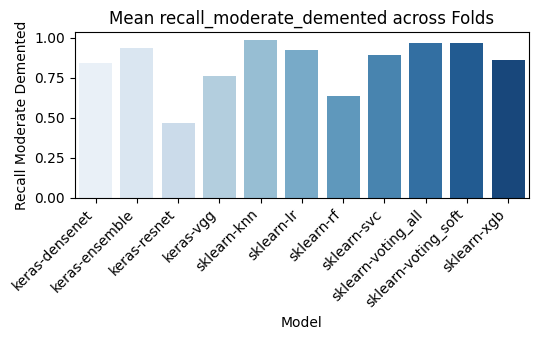

In [ ]:
import seaborn as sns

metric_to_plot = f'eval_recall_moderate_demented'

plt.figure(figsize=(5.5, 3.5))

plot_data = results_df.groupby('model_name')[metric_to_plot].mean().reset_index()
sns.barplot(data=plot_data, x='model_name', y=metric_to_plot, palette='Blues')

plt.title(f'Mean {metric_to_plot.replace("eval_", "")} across Folds')
plt.ylabel(metric_to_plot.replace('eval_','').replace('_',' ').title())
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Plot training history

In [ ]:
history_combined_df = pd.concat(history_list, ignore_index=True)
history_combined_df.head()

,epoch,epoch/val_accuracy,epoch/val_precision,epoch/loss,epoch/epoch,epoch/val_auc,epoch/learning_rate,epoch/val_recall,epoch/auc,epoch/val_loss,epoch/accuracy,epoch/recall,epoch/precision,run_id,run_name,model_name,fold
0,0,0.542969,0.671196,1.017695,0,0.838253,0.001,0.385938,0.808068,0.926427,0.539032,0.384253,0.616525,8snl2051,keras-resnet-fold-0,keras-resnet,0
1,1,0.567187,0.673469,0.845503,1,0.848669,0.001,0.412500,0.868605,0.893317,0.616517,0.501396,0.691124,8snl2051,keras-resnet-fold-0,keras-resnet,0
2,2,0.583594,0.670732,0.783722,2,0.854680,0.001,0.429688,0.887812,0.875834,0.646164,0.545866,0.716216,8snl2051,keras-resnet-fold-0,keras-resnet,0
3,3,0.585156,0.670251,0.743282,3,0.858852,0.001,0.438281,0.899504,0.863868,0.665800,0.571470,0.732782,8snl2051,keras-resnet-fold-0,keras-resnet,0
4,4,0.591406,0.672875,0.712817,4,0.862062,0.001,0.451562,0.907902,0.855021,0.683319,0.592935,0.743872,8snl2051,keras-resnet-fold-0,keras-resnet,0


In [ ]:
history_combined_df.model_name.value_counts()

,count
model_name,
keras-resnet,250
keras-densenet,250
keras-vgg,250
keras-ensemble,250


In [ ]:
def plot_ci(ax, data, metric, label, color, **kwargs) -> None:
    epochs = sorted(data['epoch'].unique())
    mean = data.groupby('epoch')[metric].mean().reindex(epochs)
    std = data.groupby('epoch')[metric].std().reindex(epochs).fillna(0)

    ax.plot(epochs, mean, label=label, color=color, alpha=0.9, **kwargs)
    ax.fill_between(epochs, mean - std, mean + std, color=color, alpha=0.13)

    return None

In [ ]:
unq_model_names = history_combined_df.model_name.unique()

model_abbr = {
    'keras-resnet': 'RN',
    'keras-densenet': 'DN',
    'keras-vgg': 'VGG',
    'keras-ensemble': 'S-CNN'
}

In [ ]:
import palettable

num_models = len(unq_model_names)

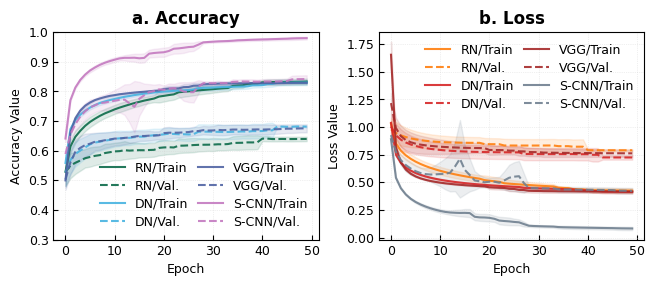

In [ ]:
sbc_single_col_width_in = 6.5
fig_height_in = 2.8
label_fs = 9
tick_fs = 9
legend_fs = 9
title_fs = 12
line_lw = 1.5

acc_plot_colors_list = ['#0C6B4A', '#47B3E0', '#5064A3', '#C47AC0']
loss_plot_colors_list = ["#ff7f0e", "#d62728", "brown", "slategray"]


fig, axs = plt.subplots(
    nrows=1, ncols=2, figsize=(sbc_single_col_width_in, fig_height_in),
    sharey=False, sharex=False,
)

for i, model_name in enumerate(unq_model_names):
    model_data = history_combined_df.query("model_name == @model_name and `epoch/epoch` <= 50")
    abbr = model_abbr.get(model_name, model_name)

    plot_ci(axs[0], model_data, 'epoch/accuracy',
            f'{abbr}/Train', acc_plot_colors_list[i], lw=line_lw)

    plot_ci(axs[0], model_data, 'epoch/val_accuracy',
            f'{abbr}/Val.', acc_plot_colors_list[i], linestyle="dashed", lw=line_lw)

    plot_ci(axs[1], model_data, 'epoch/loss', f'{abbr}/Train',
            loss_plot_colors_list[i], lw=line_lw)

    plot_ci(axs[1], model_data, 'epoch/val_loss', f'{abbr}/Val.',
            loss_plot_colors_list[i], linestyle="dashed", lw=line_lw)

axs[0].set_title('a. Accuracy', fontsize=title_fs, fontweight="bold")
axs[0].set_xlabel('Epoch', fontsize=label_fs)
axs[0].set_ylabel('Accuracy Value', fontsize=label_fs)
axs[0].grid(True, color='lightgray', linestyle=':', linewidth=0.5, alpha=0.7)
axs[0].tick_params(axis='both', which='major', labelsize=tick_fs, direction='in')
axs[0].set_ylim([0.3, 1])

axs[0].legend(
    loc='lower right',
    frameon=False,
    fancybox=False,
    ncol=2,
    fontsize=legend_fs,
    labelspacing=0.4,
    columnspacing=0.8
)

axs[1].set_title('b. Loss', fontsize=title_fs, fontweight="bold")
axs[1].set_xlabel('Epoch', fontsize=label_fs)
axs[1].set_ylabel('Loss Value', fontsize=label_fs)
axs[1].grid(True, color='lightgray', linestyle=':', linewidth=0.5, alpha=0.7)
axs[1].tick_params(axis='both', which='major', labelsize=tick_fs, direction='in')

axs[1].legend(
    loc='upper right',
    frameon=False,
    fancybox=False,
    ncol=2,
    fontsize=legend_fs,
    labelspacing=0.4,
    columnspacing=0.8
)

fig.tight_layout(pad=0.5)
plt.savefig("train_2.png", bbox_inches='tight', dpi=300)

## Statistics

In [ ]:
!pip install -qU scikit-posthocs pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 6.9 MB/s eta 0:00:00


In [ ]:
from scipy import stats
import pingouin as pg
import scikit_posthocs as sp

In [ ]:
PRIMARY_METRIC = "eval_f1_macro"
ALPHA = 0.05

In [ ]:
stats_df = (
    results_df
    .filter(regex=r'^(?!(?:history|confusion|epoch/)).*')
    .drop(["epochs", "loss_fn", "optimizer", "batch_size"], axis=1)
)

stats_df.head()

,run_name,run_id,model_name,fold,eval_accuracy,eval_auc_roc_mild_demented,eval_auc_roc_moderate_demented,eval_auc_roc_non_demented,eval_auc_roc_very_mild_demented,eval_f1_macro,...,eval_recall_macro,eval_recall_micro,eval_recall_mild_demented,eval_recall_moderate_demented,eval_recall_non_demented,eval_recall_very_mild_demented,eval_support_mild_demented,eval_support_moderate_demented,eval_support_non_demented,eval_support_very_mild_demented
0,sklearn-xgb-fold-0,ickc47iw,sklearn-xgb,0,0.976562,0.998899,1.000000,0.998501,0.997915,0.978959,...,0.974293,0.976562,0.933333,1.000000,0.990625,0.973214,180,12,640,448
1,sklearn-xgb-fold-1,vd6518ns,sklearn-xgb,1,0.975000,0.999498,1.000000,0.999087,0.998229,0.979398,...,0.974092,0.975000,0.944134,1.000000,0.996875,0.955357,179,13,640,448
2,sklearn-xgb-fold-2,ifcjmbpj,sklearn-xgb,2,0.983594,0.999767,1.000000,0.999158,0.999125,0.976448,...,0.963737,0.983594,0.955307,0.923077,0.992188,0.984375,179,13,640,448
3,sklearn-xgb-fold-3,4qjpamth,sklearn-xgb,3,0.975000,0.997833,1.000000,0.998848,0.998272,0.947323,...,0.917904,0.975000,0.938547,0.769231,0.990625,0.973214,179,13,640,448
4,sklearn-xgb-fold-4,cbowpoza,sklearn-xgb,4,0.979688,0.998772,0.985672,0.999231,0.999013,0.923595,...,0.882231,0.979688,0.932961,0.615385,0.998437,0.982143,179,13,640,448


In [ ]:
stats_df = (
    stats_df
    .pivot(index="fold", columns="model_name", values=PRIMARY_METRIC)
    .reset_index()
    .drop("fold", axis="columns")
)

stats_df

model_name,keras-densenet,keras-ensemble,keras-resnet,keras-vgg,sklearn-knn,sklearn-lr,sklearn-rf,sklearn-svc,sklearn-voting_all,sklearn-voting_soft,sklearn-xgb
0,0.705722,0.855769,0.539274,0.655773,0.981487,0.885759,0.856372,0.856084,0.970858,0.991025,0.978959
1,0.705243,0.859174,0.595670,0.690270,0.985808,0.878094,0.939117,0.882928,0.977872,0.989532,0.979398
2,0.685594,0.875474,0.551873,0.676894,0.988249,0.885130,0.909459,0.844190,0.977616,0.994337,0.976448
3,0.723187,0.876122,0.565689,0.693356,0.986669,0.885285,0.927082,0.856662,0.974070,0.991798,0.947323
4,0.667096,0.844258,0.498709,0.618892,0.978048,0.825378,0.820600,0.806393,0.956454,0.973029,0.923595


In [ ]:
pg.homoscedasticity(stats_df)

,W,pval,equal_var
levene,1.336535,0.241734,True


In [ ]:
pg.normality(stats_df)

,W,pval,normal
model_name,,,
keras-densenet,0.958019,0.794124,True
keras-ensemble,0.905889,0.443282,True
keras-resnet,0.987107,0.968614,True
keras-vgg,0.885672,0.335811,True
sklearn-knn,0.919024,0.523664,True
sklearn-lr,0.637650,0.001894,False
sklearn-rf,0.908309,0.457496,True
sklearn-svc,0.936966,0.644572,True
sklearn-voting_all,0.808620,0.095084,True


In [ ]:
pg.friedman(stats_df)

,Source,W,ddof1,Q,p-unc
Friedman,Within,0.966545,10,48.327273,5.408413e-07


In [ ]:
NAME_MAP = {
    "keras-densenet": "DenseNet",
    "keras-ensemble": "Stacking-CNN",
    "sklearn-knn": "KNN",
    "sklearn-lr": "LR",
    "keras-resnet": "ResNet",
    "sklearn-rf": "RF",
    "sklearn-svc": "SVC",
    "keras-vgg": "VGG",
    "sklearn-voting_all": "Voting[all]",
    "sklearn-voting_soft": "Voting[few]",
    "sklearn-xgb": "XGB"
}

In [ ]:
def print_stats(stat, p_value) -> None:
    print("\nStats:")
    print(f"   {stat=}")
    print(f"   {p_value=}")

    if p_value < ALPHA:
        print("[*] rejected null-hypothesis")

    else:
        print("[!] fail to reject null-hypothesis")

    return None


def hypothesis_testing(data: pd.DataFrame, verbose: bool = True) -> bool:
    # true -> rejects, false -> fail to reject
    friedman_table = data.transpose().values
    stat, p_value = stats.friedmanchisquare(*friedman_table)

    if verbose:
        print_stats(stat, p_value)

    return p_value < ALPHA


def check_normality(data: np.ndarray, verbose: bool = True) -> bool:
    stat, p_value = stats.shapiro(data)

    if verbose:
        print_stats(stat, p_value)

    return p_value < ALPHA


def check_variance(data: np.ndarray, verbose: bool = True) -> bool:
    stat, p_value = stats.levene(*data)

    if verbose:
        print_stats(stat, p_value)

    return p_value < ALPHA


def plot_posthoc_test(data: pd.DataFrame, ax) -> None:
    posthoc = sp.posthoc_nemenyi_friedman(data.values)

    posthoc.columns = data.columns
    posthoc.index = data.columns

    sns.heatmap(
        posthoc, annot=True, cmap="viridis", ax=ax,
        center=0.05, vmin=0, vmax=0.05, cbar=False, linewidths=0.4
    )
    ax.tick_params(axis="x", rotation=60)
    return None


def conduct_experiments(data: pd.DataFrame, verbose: bool = True, **plot_kwargs: dict) -> None:
    if verbose:
        print(">>> Checking data normality (Shapiro test):")
        for record in data.transpose().values:
            check_normality(record, verbose=verbose)
            print("-" * 50)

        print("\n>>> Checking data variance (Levene test):")
        _ = check_variance(data.transpose().values, verbose=verbose)

        print("\n>>> Hypothesis testing (Friedman chi^2):")
        print("   H0: Repeated samples have the same distribution")
        print("   H1: Reapeated samples are different")

    reject_h0 = hypothesis_testing(data, verbose=verbose)

    if reject_h0:
        if verbose:
            print("\nH0 rejected. Conducting Nemenyi post-hoc test:")

        plot_posthoc_test(data, **plot_kwargs)

    return None

Text(114.47222222222221, 0.5, 'Model')

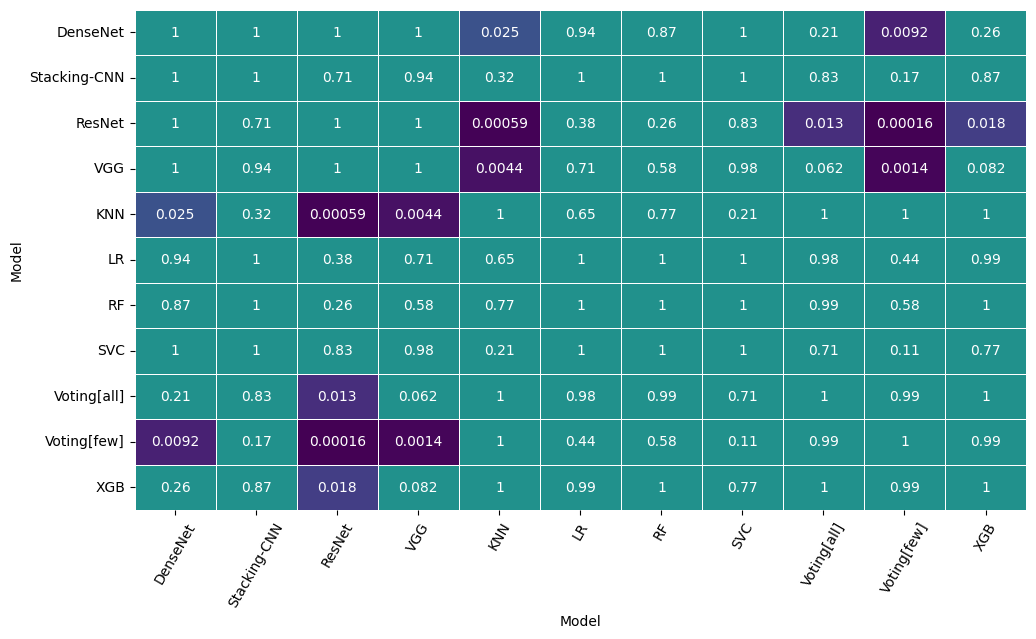

In [ ]:
_, ax = plt.subplots(figsize=(11.5, 6.5))
conduct_experiments(
    stats_df.rename(columns=NAME_MAP),
    ax=ax,
    verbose=False
)

ax.set_xlabel("Model")
ax.set_ylabel("Model")

In [ ]:
def plot_posthoc_heatmap_scientific(
    data: pd.DataFrame,
    ax: plt.Axes,
    alpha: float = 0.05,
    cmap_choice: str = "mako_r",
    fmt_annot: str = ".3f",
    add_significance_marker: bool = True,
    vmax_plot: float = 0.1,
    show_cbar: bool = True,
    cbar_label: str = 'p-value',
    tick_label_fontsize: int = 9,
    annot_fontsize: int = 9
) -> None:

    posthoc_results = sp.posthoc_nemenyi_friedman(data.values)
    posthoc_results.columns = data.columns
    posthoc_results.index = data.columns

    # mask = np.zeros_like(posthoc_results, dtype=bool)
    # mask[np.triu_indices_from(mask)] = True
    n_groups = posthoc_results.shape[0]
    mask = np.eye(n_groups, dtype=bool)

    if add_significance_marker:
        annot_labels = posthoc_results.map(
            lambda p: f"{p:{fmt_annot}}{'*' if p < alpha else ''}"
        )
        fmt_for_heatmap = 's'

    else:
        annot_labels = posthoc_results
        fmt_for_heatmap = fmt_annot

    sns.heatmap(
        posthoc_results,
        annot=annot_labels,
        fmt=fmt_for_heatmap,
        cmap=cmap_choice,
        mask=mask,
        linewidths=0.5,
        linecolor='lightgray',
        ax=ax,
        vmin=0,
        vmax=vmax_plot,
        cbar=show_cbar,
        cbar_kws={'label': cbar_label if show_cbar else None,
                  'shrink': 0.8,
                  'aspect': 30} if show_cbar else None,
        # square=True,
        annot_kws={"size": annot_fontsize}
    )

    ax.tick_params(axis="x", rotation=45, labelsize=tick_label_fontsize)
    ax.tick_params(axis="y", rotation=0, labelsize=tick_label_fontsize)

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)

    return None

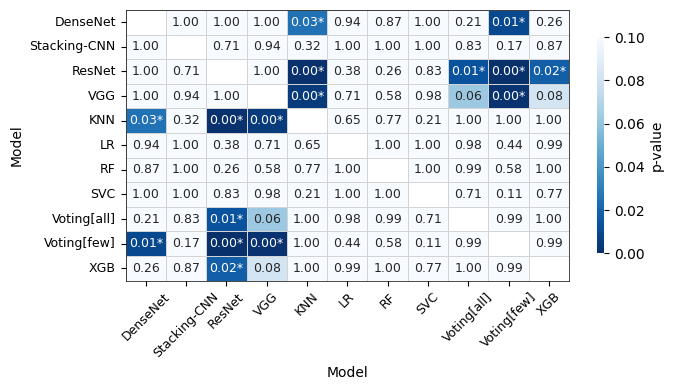

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))

plot_posthoc_heatmap_scientific(
    stats_df.rename(columns=NAME_MAP),
    ax,
    alpha=ALPHA,
    cmap_choice="Blues_r",
    vmax_plot=0.1,
    fmt_annot=".2f",
    # annot_fontsize=9
)

ax.set_xlabel("Model")
ax.set_ylabel("Model")

fig.tight_layout()
plt.savefig("cls_model_nemenyi_v2.eps", bbox_inches='tight', dpi=300)

In [ ]:
# source: https://gist.github.com/janezd/ddb7a1dc02cae624d6d84a8a39bf719a

import matplotlib.pyplot as plt
import math
from matplotlib.backends.backend_agg import FigureCanvasAgg


def compute_CD(avranks, n, alpha=0.05, test="nemenyi"):
    k = avranks if isinstance(avranks, int) else len(avranks)
    d = {("nemenyi", 0.05): [0, 0, 1.959964, 2.343701, 2.569032, 2.727774,
                               2.849705, 2.94832, 3.030879, 3.101730, 3.163684,
                               3.218654, 3.268004, 3.312739, 3.353618, 3.39123,
                               3.426041, 3.458425, 3.488685, 3.517073,
                               3.543799],
         ("nemenyi", 0.1): [0, 0, 1.644854, 2.052293, 2.291341, 2.459516,
                              2.588521, 2.692732, 2.779884, 2.854606, 2.919889,
                              2.977768, 3.029694, 3.076733, 3.119693, 3.159199,
                              3.195743, 3.229723, 3.261461, 3.291224, 3.319233],
         ("bonferroni-dunn", 0.05): [0, 0, 1.960, 2.241, 2.394, 2.498, 2.576,
                                       2.638, 2.690, 2.724, 2.773],
         ("bonferroni-dunn", 0.1): [0, 0, 1.645, 1.960, 2.128, 2.241, 2.326,
                                      2.394, 2.450, 2.498, 2.539]}
    q = d[(test, alpha)]
    cd = q[k] * (k * (k + 1) / (6.0 * n)) ** 0.5
    return cd


def graph_ranks(avranks, names, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, **kwargs):

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.
        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]
        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    tempsort = sorted([(a, i) for i, a in enumerate(sums)], reverse=reverse)
    ssums = nth(tempsort, 0)
    sortidx = nth(tempsort, 1)
    nnames = [names[x] for x in sortidx]

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    if cd and cdmethod is None:
        # get pairs of non significant methods

        def get_lines(sums, hsd):
            # get all pairs
            lsums = len(sums)
            allpairs = [(i, j) for i, j in mxrange([[lsums], [lsums]]) if j > i]
            # remove not significant
            notSig = [(i, j) for i, j in allpairs
                      if abs(sums[i] - sums[j]) <= hsd]
            # keep only longest

            def no_longer(ij_tuple, notSig):
                i, j = ij_tuple
                for i1, j1 in notSig:
                    if (i1 <= i and j1 > j) or (i1 < i and j1 >= j):
                        return False
                return True

            longest = [(i, j) for i, j in notSig if no_longer((i, j), notSig)]

            return longest

        lines = get_lines(ssums, cd)
        linesblank = 0.2 + 0.2 + (len(lines) - 1) * 0.1

        # add scale
        distanceh = 0.25
        cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]


    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=0.7)

    bigtick = 0.1
    smalltick = 0.05

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=0.7)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom")

    k = len(ssums)

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=0.7)
        text(textspace - 0.2, chei, nnames[i], ha="right", va="center")

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=0.7)
        text(textspace + scalewidth + 0.2, chei, nnames[i],
             ha="left", va="center")

    if cd and cdmethod is None:
        # upper scale
        if not reverse:
            begin, end = rankpos(lowv), rankpos(lowv + cd)
        else:
            begin, end = rankpos(highv), rankpos(highv - cd)

        line([(begin, distanceh), (end, distanceh)], linewidth=0.7)
        line([(begin, distanceh + bigtick / 2),
              (begin, distanceh - bigtick / 2)],
             linewidth=0.7)
        line([(end, distanceh + bigtick / 2),
              (end, distanceh - bigtick / 2)],
             linewidth=0.7)
        text((begin + end) / 2, distanceh - 0.05, "CD",
             ha="center", va="bottom")

        # no-significance lines
        def draw_lines(lines, side=0.05, height=0.1):
            start = cline + 0.2
            for l, r in lines:
                line([(rankpos(ssums[l]) - side, start),
                      (rankpos(ssums[r]) + side, start)],
                     linewidth=2.5)
                start += height

        draw_lines(lines)

    elif cd:
        begin = rankpos(avranks[cdmethod] - cd)
        end = rankpos(avranks[cdmethod] + cd)
        line([(begin, cline), (end, cline)],
             linewidth=2.5)
        line([(begin, cline + bigtick / 2),
              (begin, cline - bigtick / 2)],
             linewidth=2.5)
        line([(end, cline + bigtick / 2),
              (end, cline - bigtick / 2)],
             linewidth=2.5)

    if filename:
        print_figure(fig, filename, **kwargs)

    return fig, ax

In [ ]:
data = stats_df.copy().rename(columns=NAME_MAP)
data

model_name,DenseNet,Stacking-CNN,ResNet,VGG,KNN,LR,RF,SVC,Voting[all],Voting[few],XGB
0,0.705722,0.855769,0.539274,0.655773,0.981487,0.885759,0.856372,0.856084,0.970858,0.991025,0.978959
1,0.705243,0.859174,0.595670,0.690270,0.985808,0.878094,0.939117,0.882928,0.977872,0.989532,0.979398
2,0.685594,0.875474,0.551873,0.676894,0.988249,0.885130,0.909459,0.844190,0.977616,0.994337,0.976448
3,0.723187,0.876122,0.565689,0.693356,0.986669,0.885285,0.927082,0.856662,0.974070,0.991798,0.947323
4,0.667096,0.844258,0.498709,0.618892,0.978048,0.825378,0.820600,0.806393,0.956454,0.973029,0.923595


In [ ]:
ranks = np.array([stats.rankdata(-p) for p in data.values])
average_ranks = np.mean(ranks, axis=0)
cd = compute_CD(average_ranks, n=len(data), alpha=0.05, test='nemenyi')

In [ ]:
print(ranks)
print("=" * 30)
print(average_ranks)
print("=" * 30)
print(cd)

[[ 9.  8. 11. 10.  2.  5.  6.  7.  4.  1.  3.]
 [ 9.  8. 11. 10.  2.  7.  5.  6.  4.  1.  3.]
 [ 9.  7. 11. 10.  2.  6.  5.  8.  3.  1.  4.]
 [ 9.  7. 11. 10.  2.  6.  5.  8.  3.  1.  4.]
 [ 9.  5. 11. 10.  1.  6.  7.  8.  3.  2.  4.]]
[ 9.   7.  11.  10.   1.8  6.   5.6  7.4  3.4  1.2  3.6]
6.751505588796502


In [ ]:
plt.rcParams.update({"font.size": 15})

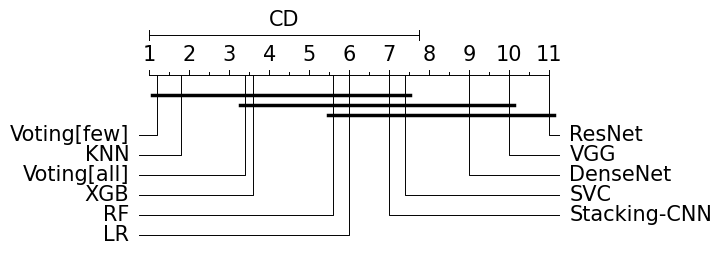

In [ ]:
fig, ax = graph_ranks(average_ranks, names=data.columns.tolist(), cd=cd)
plt.savefig("cd_cls_v2.eps", bbox_inches='tight', dpi=300)